In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import yfinance as yf

## Yahoo Finance API

### Get Data

A ticker (or ticker symbol) is a unique abbreviation used to identify a publicly traded company on a stock exchange.

In [31]:
tickers = ['XWD.TO', 'IWDA.AS', 'NVDA']
tickers = {ticker:yf.Ticker(ticker) for ticker in tickers}

print('We are looking at the following stocks:')
for t in tickers:
    print(t, '-',tickers[t].info['longName'])

We are looking at the following stocks:
XWD.TO - iShares MSCI World Index ETF
IWDA.AS - iShares Core MSCI World UCITS ETF USD (Acc)
NVDA - NVIDIA Corporation


### Sector Weighting for ETFs

In [51]:
ticker = yf.Ticker('IWDA.AS')

print(ticker.info['longName'])
print(ticker.funds_data.sector_weightings)

iShares Core MSCI World UCITS ETF USD (Acc)
{'realestate': 0.0219, 'consumer_cyclical': 0.1003, 'basic_materials': 0.0318, 'consumer_defensive': 0.0661, 'technology': 0.2527, 'communication_services': 0.08180001, 'financial_services': 0.1674, 'utilities': 0.027, 'industrials': 0.1058, 'energy': 0.0367, 'healthcare': 0.1084}


### Country Weighting for ETFs

In [ ]:
Tickers = {
    "XWD.TO":"MSCI_World (Index)",
    "IWDA.AS":"iShares Core MSCI World UCITS ETF USD (Acc)", # AS stands for Amsterdam I think (IWDA.L is on London)
    "NVDA":"NVIDIA Corporation",
}

data_countries = {}
for ticker in Tickers:

    data_countries[ticker] = yf.download(ticker, start="1970-1-2")

/tmp/ipykernel_14897/1541044955.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[ticker] = yf.download(ticker, start="1970-1-2")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_14897/1541044955.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[ticker] = yf.download(ticker, start="1970-1-2")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_14897/1541044955.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[ticker] = yf.download(ticker, start="1970-1-2")
[*********************100%***********************]  1 of 1 completed


In [ ]:
data_countries['IWDA.AS']

Price,Close,High,Low,Open,Volume
Ticker,IWDA.AS,IWDA.AS,IWDA.AS,IWDA.AS,IWDA.AS
Date,,,,,
2009-09-25,16.990000,16.990000,16.990000,16.990000,0
2009-09-28,16.990000,16.990000,16.990000,16.990000,0
2009-09-29,16.990000,16.990000,16.990000,16.990000,0
2009-09-30,16.990000,16.990000,16.990000,16.990000,0
2009-10-01,16.990000,16.990000,16.990000,16.990000,0
...,...,...,...,...,...
2025-06-12,99.574997,99.800003,98.660004,99.754997,128429
2025-06-13,99.245003,99.599998,98.550003,98.714996,123959


### Compare prices

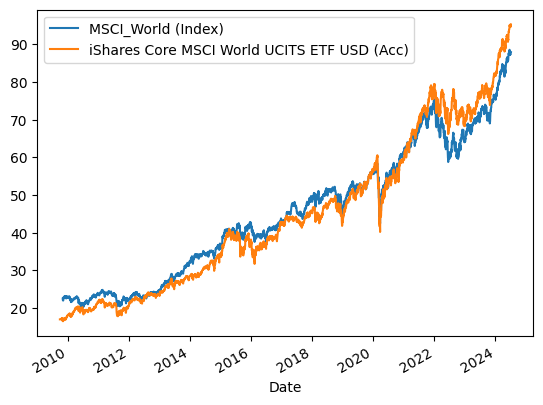

In [ ]:
fig, ax = plt.subplots()

tickers_to_compare = ["XWD.TO", "IWDA.AS"]
for ticker in tickers_to_compare:
    data_countries[ticker]["Close"].plot(ax=ax, label=Tickers[ticker])

ax.legend()
plt.show()

### Analyze

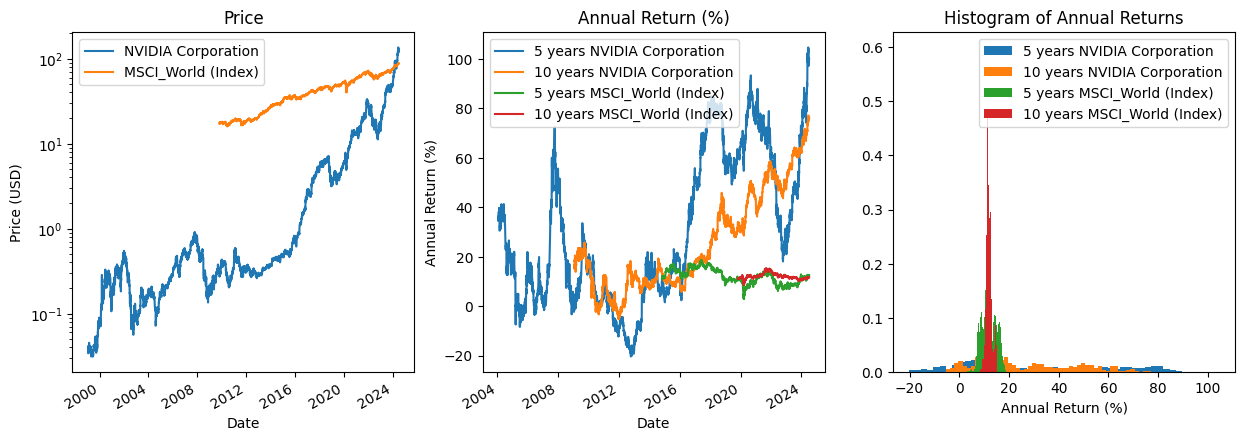

In [ ]:
tickers_to_compare = ["NVDA", "XWD.TO"]
years_holding_list = [5, 10]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title("Price")
ax[1].set_title("Annual Return (%)")
ax[2].set_title("Histogram of Annual Returns")

for ticker in tickers_to_compare:

    etf_data = data_countries[ticker]
    df = etf_data["Adj Close"].to_frame().rename(columns = {'Adj Close':"Price"})

    df['Price'].plot(ax=ax[0], label=Tickers[ticker])

    for years_holding in years_holding_list:

        num_days = (df.index[-1]-df.index[0]).days
        num_recorded_days = len(df)
        recorded_days_per_year = 365*(num_recorded_days / num_days)
        recorded_days_holding = int(recorded_days_per_year*years_holding)
        
        shifted_price = df['Price'].shift(recorded_days_holding) # shifts the prices forward, putting NaN before
        
        df['return'] = (df['Price'] - shifted_price)/shifted_price # total return after years_holding
        df['return'] = (df['return'] + 1) ** (1/years_holding) - 1 # annualized return
        df['return'] = df['return']*100 # percentage
        #shifted_price.plot(ax=ax[0])

        df['return'].plot(ax=ax[1], label=f"{years_holding} years {Tickers[ticker]}")
        df['return'].hist(ax=ax[2], bins=50, label=f"{years_holding} years {Tickers[ticker]}", density=True)

ax[0].set_yscale("log")
ax[0].set_ylabel("Price (USD)")
ax[0].legend()

ax[1].set_ylabel("Annual Return (%)")
ax[1].legend()

ax[2].set_xlabel("Annual Return (%)")
ax[2].grid(False)
ax[2].legend()

plt.show()

In [ ]:
# Strategy: 
# sell if the current return is above R%
# buy if the value drops below of L% with respect to the last sell
# OR buy if more than Z days have passed since the last sell

# Parameters:
R = 0.8 # %
L = -0.02 # %
Z = 5

ETF = "IWDA.AS"
years_holding = 5

etf_data = data_countries[ETF]
df = etf_data["Adj Close"].to_frame().rename(columns = {'Adj Close':"Price"})

num_days = (df.index[-1]-df.index[0]).days
num_recorded_days = len(df)
recorded_days_per_year = 365*(num_recorded_days / num_days)
recorded_days_holding = int(recorded_days_per_year*years_holding)

num_periods = len(df) - recorded_days_holding
results = []

for i in tqdm(range(num_periods)):

    period = df.index[i:i+recorded_days_holding]
    initial_buy_day = period[0]

    initial_investment_value = 100
    final_investment_value = initial_investment_value

    buy_days = [initial_buy_day,]
    buy_prices = [df['Price'].loc[initial_buy_day],]
    sell_days = []
    sell_prices = []

    last_buy_price = df['Price'].loc[initial_buy_day]
    last_sell_price = 0.
    holding = True

    for day in period[1:]:

        current_price = df['Price'].loc[day]
        
        if holding:
            current_return = (current_price - last_buy_price)/last_buy_price

            if current_return > R:
                sell_days.append(day)
                sell_prices.append(current_price)
                final_investment_value += final_investment_value*current_return
                last_sell_price = current_price
                holding = False

        else:
            current_variation = (current_price - last_sell_price)/last_sell_price

            if current_variation < L or (day - sell_days[-1]).days > Z:
                buy_days.append(day)
                buy_prices.append(current_price)

                last_buy_price = current_price
                holding = True
            

    total_return = (final_investment_value - initial_investment_value)/initial_investment_value
    yearly_return = (1 + total_return)**(1/years_holding) - 1
    yearly_return = yearly_return*100

    total_return_no_strategy = (df['Price'].loc[period[-1]] - df['Price'].loc[period[0]])/df['Price'].loc[period[0]]
    yearly_return_no_strategy = (1 + total_return_no_strategy)**(1/years_holding) - 1
    yearly_return_no_strategy = yearly_return_no_strategy*100

    results.append(
        {
            "initial_buy_day":initial_buy_day,
            "yearly_return":yearly_return,
            "yearly_return_no_strategy":yearly_return_no_strategy,
            "sell_days":sell_days,
            "sell_prices":sell_prices,
            "buy_days":buy_days,
            "buy_prices":buy_prices
        }
    )

100%|██████████| 2504/2504 [00:28<00:00, 88.01it/s]


0.0 7.868722393921544 12.496947816637515 12.880836781870975
0.3113833367127228 11.810246660351595 12.099892245765687 16.937508546484036


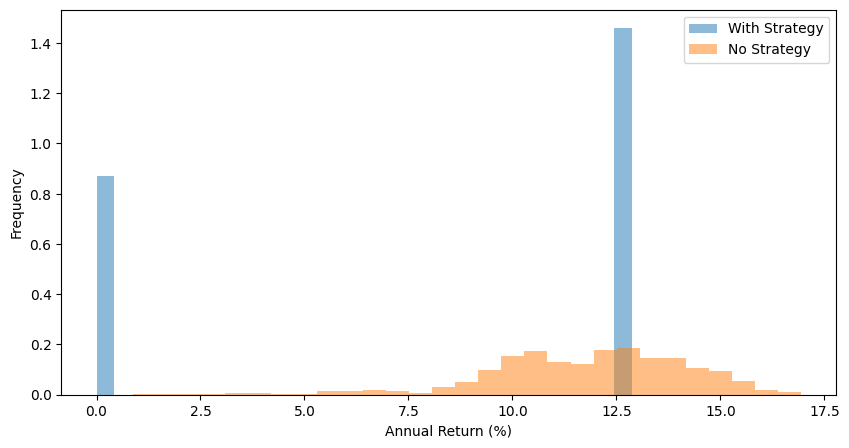

In [118]:
fig, ax = plt.subplots(figsize=(10, 5))

returns = [result["yearly_return"] for result in results]
returns_no_strategy = [result["yearly_return_no_strategy"] for result in results]

print(min(returns), np.mean(returns), np.median(returns), max(returns))
print(min(returns_no_strategy), np.mean(returns_no_strategy), np.median(returns_no_strategy), max(returns_no_strategy))

ax.hist(returns, bins=30, alpha=0.5, label="With Strategy", density=True)
ax.hist(returns_no_strategy, bins=30, alpha=0.5, label="No Strategy", density=True)

ax.set_xlabel("Annual Return (%)")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

## JustETF Scraping 

JustETF does not provide an API endpoint for ETFs data.
Why would it? It wants people to use its website, of course.
Anyway, we have to scrape the data we need from the website.

Unfortunately, not all the data we need are contained by default in the html page of a certain ETF.
In fact, there are some (Java)scripts that make more or less content to be loaded. 
For example, we need to click a 'Show more' button in order to see the full list of countries the ETF has holdings in.

This complicates things a bit.
Getting the html page as a string using the python built-in module 'requests', then search the string with 're', was relatively easy.
But no, we need to actually intereact with the page.
We need to use selenium.

**In short**: we need to use 'selenium' because justETF pages are *dynamic pages* and not not *static HTML pages*.

### Selenium

Among other things, Selenium supports headless browsing, which means you can run the browser without a graphical user interface (GUI).

To use Selenium, a supported Browser and the corresponding WebDriver must be installed on your system.
For example, I use Brave Broswer.
This is not officially supported by Selenium, but it is actually fully based on Chromium, so it should work with the appropriate WebDriver.

So first question: how do we find out which Chromium version is Brave using? Just navigate to this page from Brave browser: 'brave://version/'

Now I download the ChromeDriver from the Chrome official website (https://developer.chrome.com/docs/chromedriver/get-started/).

In [25]:
from selenium import webdriver

# options is an object with some dictionaries, variables, lists. All for you to change.
# You can change them directly, or using some interface methods.
options = webdriver.ChromeOptions()

# Notice that we are tricking selenium, making it think that the browser is Chrome
print(options.capabilities['browserName'])

# but we secretely change the binary to brave-browser 
options.binary_location = '/usr/bin/brave-browser' #/home/lorenzos/.local/bin/chrome-linux64/chrome'

# we manually tell which binary to use for the driver, just for sport we could also just put in the PATH (https://www.selenium.dev/documentation/webdriver/drivers/)
service = webdriver.ChromeService(executable_path='/home/lorenzos/.local/bin/chromedriver-linux64/chromedriver')

# ready to run the driver!
driver = webdriver.Chrome(options=options,
                          service=service)  # Optional argument, if not specified will search path.

chrome


In [ ]:
from selenium.webdriver.common.by import By

# we can locate all the elements of the class 'headline', and print the text
# just explore the object headline to get more information
headlines = driver.find_elements(By.CLASS_NAME, 'headline')

for headline in headlines:
    print(headline.text)

In [ ]:
# Countries is an h3 element, let us find all of them!

h3_elements = driver.find_elements(By.TAG_NAME, "h3")

# Print the text of each <h3>
for h3 in h3_elements:
    print(h3.text)

#### Get countries and percentages from ETF profile page

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep

options = webdriver.ChromeOptions()
options.binary_location = '/home/lorenzos/.local/bin/chrome-linux64/chrome'
options.add_argument('--headless=new')
options.add_argument('--disable-gpu')
service = webdriver.ChromeService(executable_path='/home/lorenzos/.local/bin/chromedriver-linux64/chromedriver')
driver = webdriver.Chrome(options=options,
                          service=service)

basic_url = 'https://www.justetf.com/en/etf-profile.html?isin='
ISIN = 'IE00B4L5Y983'

driver.get(basic_url+ISIN)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep

options = webdriver.ChromeOptions()
options.binary_location = '/home/lorenzos/.local/bin/chrome-linux64/chrome' #'/usr/bin/brave-browser'
options.add_argument('--headless=new')
options.add_argument('--disable-gpu')
service = webdriver.ChromeService(executable_path='/home/lorenzos/.local/bin/chromedriver-linux64/chromedriver')
driver = webdriver.Chrome(options=options,
                          service=service)

basic_url = 'https://www.justetf.com/en/etf-profile.html?isin='
ISIN = 'IE00B4L5Y983'

driver.get(basic_url+ISIN)

wait = WebDriverWait(driver, 10) # with this we only wait as long as the element is ready, up to 10 seconds, much better than sleep

# STEP 1: Find the parent <div> that contains <h3>Countries
container_countries = wait.until(EC.presence_of_element_located(
    (By.XPATH, "//h3[normalize-space()='Countries']/ancestor::div[1]")
))

container_sectors = wait.until(EC.presence_of_element_located(
    (By.XPATH, "//h3[normalize-space()='Sectors']/ancestor::div[1]")
))

# STEP 2: Click the 'a' element in the container
show_more_button_countries = container_countries.find_element(By.TAG_NAME, "a")
show_more_button_sectors = container_sectors.find_element(By.TAG_NAME, "a")

driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", show_more_button_countries)
driver.execute_script("arguments[0].click();", show_more_button_countries)
sleep(0.1)

driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", show_more_button_sectors)
driver.execute_script("arguments[0].click();", show_more_button_sectors)
sleep(0.1)

# table = driver.find_element(By.XPATH, "//h3[normalize-space()='Countries']/following-sibling::table")
table_countries = container_countries.find_element(By.TAG_NAME, "table")
# table_sectors = container_sectors.find_element(By.TAG_NAME, "table")


rows_countries = table_countries.find_elements(By.TAG_NAME, "tr")

# Extract data
data_countries = []
for row in rows_countries:
    cells = row.find_elements(By.TAG_NAME, "td")
    if len(cells) >= 2:
        country = cells[0].text.strip()
        percentage = cells[1].find_element(By.TAG_NAME, "span").text.strip()
        data_countries.append((country, percentage))

# rows_sectors = table_countries.find_elements(By.TAG_NAME, "tr")
# data_sectors = []
# for row in rows_sectors:
#     cells = row.find_elements(By.TAG_NAME, "td")
#     if len(cells) >= 2:
#         sector = cells[0].text.strip()
#         percentage = cells[1].find_element(By.TAG_NAME, "span").text.strip()
#         data_sectors.append((sector, percentage))

# Print extracted data
print("COUNTRIES")
for country, percentage in data_countries:
    print(f"{country}: {percentage}")

# print("SECTORS")
# for sector, percentage in data_sectors:
#     print(f"{sector}: {percentage}")


# driver.quit()

COUNTRIES
: 
: 
: 
: 
: 
: 
: 
: 
: 
: 
